In [1]:
from __future__ import print_function
import glob
from itertools import chain
import os
import cv2
import csv
import random
import zipfile
import os.path as osp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from functools import reduce
import torch.nn as nn
from einops import rearrange, repeat
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision.transforms import ToPILImage
# from linformer import Linformer
from PIL import Image
from imgaug import augmenters as iaa
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
# from vit_pytorch.efficient import ViT
# from model import BiSeNet
import torchvision.transforms as transforms
from skimage import io, img_as_float
import timm

In [2]:
seed = 17
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [3]:
test_dir_real = '/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Datasets/DeepfakeDetection/DFDC/Cleaned_Data/Images/test_set_real/'
test_dir_fake = '/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Datasets/DeepfakeDetection/DFDC/Cleaned_Data/Images/test_set_fake/'


In [4]:
device = 'cuda'
# device = 'cpu'

In [5]:
import timm
models = ['xception', 'res2net101_26w_4s', 'tf_efficientnet_b7_ns', 'vit_base_patch16_224', 'swin_base_patch4_window7_224', 'mvitv2_base']
# augs = ['No_Augmentations', 'Random_Cut_Out_Augs', 'Face_Cut_Out_Augs']
datasets = ['FakeAVCeleb', 'FaceForensics', 'DFDC', 'ForgeryNet']
model_name = models[5]
model = timm.create_model(model_name, pretrained=True, num_classes=2).to(device)

In [6]:
PATH = '../model_weights/supervised_models/mvitv2_base/Random_Cut_Out_Augs/FaceForensics/4_epochs.pth'

model.load_state_dict(torch.load(PATH), strict=True)
model.to(device)
model.eval()

MultiScaleVit(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 96, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
  )
  (stages): ModuleList(
    (0): MultiScaleVitStage(
      (blocks): ModuleList(
        (0): MultiScaleBlock(
          (norm1): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (attn): MultiScaleAttention(
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (proj): Linear(in_features=96, out_features=96, bias=True)
            (pool_q): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=96, bias=False)
            (norm_q): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
            (pool_k): Conv2d(96, 96, kernel_size=(3, 3), stride=(4, 4), padding=(1, 1), groups=96, bias=False)
            (norm_k): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
            (pool_v): Conv2d(96, 96, kernel_size=(3, 3), stride=(4, 4), padding=(1, 1), groups=96, bias=False)
            (norm_v): LayerN

# Evaluate on Videos

In [7]:
videos = sorted(glob.glob('/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Datasets/DeepfakeDetection/DFDC/Cleaned_Data/Images/test_set_real/*/'))
videos = [path.replace('\\','/') for path in videos]
len(videos)

200

In [8]:
# model.eval()
labels_map = ["fake", "real"]
count = 0
predictions = {}
probs = {}
for vid in videos:
    count+=1
    print(count)
    fake_prob = 0
    real_prob = 0
#     print(vid)
    images = sorted(glob.glob('/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Datasets/DeepfakeDetection/DFDC/Cleaned_Data/Images/test_set_real/'+str(vid.split('/')[-2])+'/*.png'))
    images = [path.replace('\\','/') for path in images]
    if len(images) >= 8:
        for image in images[:16]:
            img = Image.open(image)
            tfms = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(),
                                       transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                      ])
            img = tfms(img)
            with torch.no_grad():
                outputs = model(img.unsqueeze(0).to(device))
            for idx in torch.topk(outputs[0], k=1).indices.tolist():
                prob = torch.softmax(outputs[0], 0)[idx].item()
                if labels_map[idx] == 'fake':
                    fake_prob += prob
                    real_prob += 1-prob
                else:
                    real_prob += prob
                    fake_prob += 1 - prob
        if real_prob > fake_prob:
            predictions[vid.split('/')[-2]] = [(real_prob/len(images[:16])), 1, 1]
            probs[vid.split('/')[-2]] = (real_prob/len(images[:16]))
#             print(image)
            print('real', real_prob/len(images[:16]))
        else:
            predictions[vid.split('/')[-2]] = [1-(fake_prob/len(images[:16])), 0, 1]
            probs[vid.split('/')[-2]] = 1-(fake_prob/len(images[:16]))
            print(image)
            print('fake', fake_prob/len(images[:16]))
    else:
        print("Less than 16 frames in: ", vid)
    print('--------------')
#     break

1
real 0.5388017259538174
--------------
2
real 0.9980966858565807
--------------
3
/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Datasets/DeepfakeDetection/DFDC/Cleaned_Data/Images/test_set_real/ajiyrjfyzp/0042.png
fake 0.5658128075301647
--------------
4
real 0.9717590138316154
--------------
5
real 0.9655304923653603
--------------
6
real 0.5139295607805252
--------------
7
real 0.7250590398907661
--------------
8
real 0.8559328652918339
--------------
9
real 0.637321088463068
--------------
10
real 0.898256242275238
--------------
11
real 0.992893073707819
--------------
12
real 0.6326622329652309
--------------
13
real 0.7631542570888996
--------------
14
real 0.7511923760175705
--------------
15
real 0.9993756227195263
--------------
16
/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Datasets/DeepfakeDetection/DFDC/Cleaned_Data/Images/test_set_real/bvpeerislp/0026.png
fake 0.9708520956337452
--------------
17
real 0.9597454890608788
--------------
18
r

real 0.6256966665387154
--------------
121
real 0.852509468793869
--------------
122
real 0.9967128187417984
--------------
123
real 0.9938463121652603
--------------
124
real 0.718260508030653
--------------
125
real 0.6734441071748734
--------------
126
real 0.5304433591663837
--------------
127
real 0.5676354095339775
--------------
128
real 0.9666084833443165
--------------
129
real 0.9943217933177948
--------------
130
real 0.7826214917004108
--------------
131
/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Datasets/DeepfakeDetection/DFDC/Cleaned_Data/Images/test_set_real/qswlzfgcgj/0026.png
fake 0.8735787943005562
--------------
132
real 0.9499174244701862
--------------
133
real 0.6242029331624508
--------------
134
real 0.9120418541133404
--------------
135
real 0.9575402587652206
--------------
136
real 0.5654544457793236
--------------
137
real 0.992861695587635
--------------
138
/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Datasets/DeepfakeDete

In [98]:
originallabel = 'REAL'
# originallabel = 'FAKE'

folder_path = ('TestScores/Image/dfdc/with_augs/')
with open(folder_path + model_name + '_' + 'results' + '_' + originallabel + '.csv', 'w') as csvfile:
    fieldnames = ['Video', 'ProbabilityScore', 'PredictedLabel', 'OriginalLabel']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames, lineterminator='\n',)

    writer.writeheader()
    for i in range(len(predictions)):
        vid = list(predictions)[i]
        writer.writerow({'Video': list(predictions)[i], 'ProbabilityScore': predictions[vid][0], 'PredictedLabel': predictions[vid][1], 'OriginalLabel': predictions[vid][2]})


In [9]:
videos = sorted(glob.glob('/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Datasets/DeepfakeDetection/DFDC/Cleaned_Data/Images/test_set_fake/*/'))
videos = [path.replace('\\','/') for path in videos]

len(videos)

200

In [10]:
# model.eval()
labels_map = ["fake", "real"]
count = 0
predictions = {}
probs = {}
for vid in videos:
    count+=1
    print(count)
    fake_prob = 0
    real_prob = 0
#     print(vid)
    images = sorted(glob.glob('/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Datasets/DeepfakeDetection/DFDC/Cleaned_Data/Images/test_set_fake/'+str(vid.split('/')[-2])+'/*.png'))
    images = [path.replace('\\','/') for path in images]
    if len(images) >= 12:
        for image in images[:16]:
            img = Image.open(image)
            tfms = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(),
                                       transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                      ])
            img = tfms(img)
            with torch.no_grad():
                outputs = model(img.unsqueeze(0).to(device))
            for idx in torch.topk(outputs[0], k=1).indices.tolist():
                prob = torch.softmax(outputs[0], 0)[idx].item()
                if labels_map[idx] == 'fake':
                    fake_prob += prob
                    real_prob += 1-prob
                else:
                    real_prob += prob
                    fake_prob += 1 - prob
        if real_prob > fake_prob:
            predictions[vid.split('/')[-2]] = [(real_prob/len(images[:16])), 1, 0]
            probs[vid.split('/')[-2]] = (real_prob/len(images[:16]))
            print(image)
            print('real', real_prob/len(images[:16]))
        else:
            predictions[vid.split('/')[-2]] = [1-(fake_prob/len(images[:16])), 0, 0]
            probs[vid.split('/')[-2]] = 1-(fake_prob/len(images[:16]))
#             print(image)
            print('fake', fake_prob/len(images[:16]))
    else:
        print("Less than 16 frames in: ", vid)
    print('--------------')
#     break

1
fake 0.8372793197631836
--------------
2
fake 0.8274024575948715
--------------
3
/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Datasets/DeepfakeDetection/DFDC/Cleaned_Data/Images/test_set_fake/ahjnxtiamx/0026.png
real 0.8644373677670956
--------------
4
/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Datasets/DeepfakeDetection/DFDC/Cleaned_Data/Images/test_set_fake/aktnlyqpah/0026.png
real 0.9781912118196487
--------------
5
/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Datasets/DeepfakeDetection/DFDC/Cleaned_Data/Images/test_set_fake/alrtntfxtd/0026.png
real 0.6334218531847
--------------
6
fake 0.9824988432228565
--------------
7
/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Datasets/DeepfakeDetection/DFDC/Cleaned_Data/Images/test_set_fake/aqrsylrzgi/0026.png
real 0.7800720557570457
--------------
8
/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Datasets/DeepfakeDetection/DFDC/Cleaned_Data/Images/test_set_fake

/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Datasets/DeepfakeDetection/DFDC/Cleaned_Data/Images/test_set_fake/hsbljbsgxr/0026.png
real 0.888521034270525
--------------
66
/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Datasets/DeepfakeDetection/DFDC/Cleaned_Data/Images/test_set_fake/huvlwkxoxm/0026.png
real 0.6173419468104839
--------------
67
fake 0.8429040126502514
--------------
68
/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Datasets/DeepfakeDetection/DFDC/Cleaned_Data/Images/test_set_fake/hxwtsaydal/0328.png
real 0.6557575315237045
--------------
69
/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Datasets/DeepfakeDetection/DFDC/Cleaned_Data/Images/test_set_fake/hyjqolupxn/0026.png
real 0.8080853223800659
--------------
70
/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Datasets/DeepfakeDetection/DFDC/Cleaned_Data/Images/test_set_fake/hzoiotcykp/0203.png
real 0.7902362197637558
--------------
71
fake 0.8485877

fake 0.6559492386877537
--------------
131
fake 0.7602220810949802
--------------
132
/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Datasets/DeepfakeDetection/DFDC/Cleaned_Data/Images/test_set_fake/rcjfxxhcal/0026.png
real 0.8325689621269703
--------------
133
fake 0.9315321557223797
--------------
134
/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Datasets/DeepfakeDetection/DFDC/Cleaned_Data/Images/test_set_fake/rfjuhbnlro/0026.png
real 0.8561548218131065
--------------
135
fake 0.7824603356420994
--------------
136
/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Datasets/DeepfakeDetection/DFDC/Cleaned_Data/Images/test_set_fake/rklawjhbpv/0026.png
real 0.7053828090429306
--------------
137
/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Datasets/DeepfakeDetection/DFDC/Cleaned_Data/Images/test_set_fake/rnfcjxynfa/0026.png
real 0.6472697146236897
--------------
138
fake 0.8112879619002342
--------------
139
/Users/Sohail/Desktop/Res

fake 0.5840752571821213
--------------
192
fake 0.9565732218325138
--------------
193
fake 0.9599973298609257
--------------
194
/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Datasets/DeepfakeDetection/DFDC/Cleaned_Data/Images/test_set_fake/yxadevzohx/0026.png
real 0.760325126349926
--------------
195
/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Datasets/DeepfakeDetection/DFDC/Cleaned_Data/Images/test_set_fake/yxirnfyijn/0026.png
real 0.810347992926836
--------------
196
/Users/Sohail/Desktop/Research/PhD/Year1/NewDeepfakeDetector/Datasets/DeepfakeDetection/DFDC/Cleaned_Data/Images/test_set_fake/yzuestxcbq/0026.png
real 0.7815691232681274
--------------
197
fake 0.9286045581102371
--------------
198
fake 0.9759363606572151
--------------
199
fake 0.6078822463750839
--------------
200
fake 0.5176428779959679
--------------


In [101]:
# originallabel = 'REAL'
originallabel = 'FAKE'

folder_path = ('TestScores/Image/dfdc/with_augs/')
with open(folder_path + model_name + '_' + 'results' + '_' + originallabel + '.csv', 'w') as csvfile:
    fieldnames = ['Video', 'ProbabilityScore', 'PredictedLabel', 'OriginalLabel']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames, lineterminator='\n',)

    writer.writeheader()
    for i in range(len(predictions)):
        vid = list(predictions)[i]
        writer.writerow({'Video': list(predictions)[i], 'ProbabilityScore': predictions[vid][0], 'PredictedLabel': predictions[vid][1], 'OriginalLabel': predictions[vid][2]})


In [80]:
(predictions['aayfryxljh'])[2]

1

# Evaluate on single image

In [26]:
net.eval()


MultiScaleVit(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 96, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
  )
  (stages): ModuleList(
    (0): MultiScaleVitStage(
      (blocks): ModuleList(
        (0): MultiScaleBlock(
          (norm1): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (attn): MultiScaleAttention(
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (proj): Linear(in_features=96, out_features=96, bias=True)
            (pool_q): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=96, bias=False)
            (norm_q): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
            (pool_k): Conv2d(96, 96, kernel_size=(3, 3), stride=(4, 4), padding=(1, 1), groups=96, bias=False)
            (norm_k): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
            (pool_v): Conv2d(96, 96, kernel_size=(3, 3), stride=(4, 4), padding=(1, 1), groups=96, bias=False)
            (norm_v): LayerN

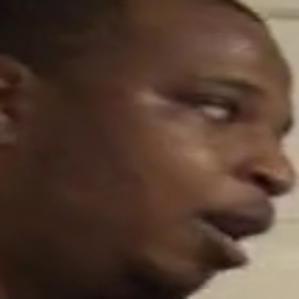

In [46]:
img = Image.open('../Datasets/DeepfakeDetection/DFDC/Cleaned_Data/Images/test_set_real/bfdopzvxbi/0011.png')
img

In [47]:
tfms = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(), 
                           transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),])
img = tfms(img)

In [48]:
labels_map = ["fake", "real"]
# Preprocess image

# Classify

probs = {}
with torch.no_grad():
    outputs = net(img.unsqueeze(0).to(device))
print('-----')
for idx in torch.topk(outputs[0], k=2).indices.tolist():
    prob = torch.softmax(outputs[0], 0)[idx].item()
    probs[idx] = (labels_map[idx], prob*100)
    print((labels_map[idx], prob*100))
#     print('[{idx}] {label:<75} ({p:.2f}%)'.format(idx=idx, label=labels_map[idx], p=prob*100))

-----
('real', 97.11257815361023)
('fake', 2.8874190524220467)


In [64]:
# model.eval()
labels_map = ["fake", "real"]
count = 0
predictions = {}
probs = {}
for vid in videos:
    count+=1
    print(count)
    fake_prob = 0
    real_prob = 0
#     print(vid)
    images = sorted(glob.glob('../Datasets/DeepfakeDetection/DFDC/Cleaned_Data/Images/test_set_real/'+str(vid.split('/')[-2])+'/*.png'))
    images = [path.replace('\\','/') for path in images]
    if len(images) >= 12:
        for image in images:
            img = Image.open(image)
            tfms = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(),
                                       transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                      ])
            img = tfms(img)
            with torch.no_grad():
                outputs = net(img.unsqueeze(0).to(device))
            for idx in torch.topk(outputs[0], k=1).indices.tolist():
                prob = torch.softmax(outputs[0], 0)[idx].item()
                if labels_map[idx] == 'fake':
                    fake_prob += prob
                    real_prob += 1-prob
                else:
                    real_prob += prob
                    fake_prob += 1 - prob
        if real_prob > fake_prob:
            predictions[vid.split('/')[-2]] = 1
            probs[vid.split('/')[-2]] = (real_prob/len(images))
#             print(image)
#             print('real', real_prob/len(images))
        else:
            predictions[vid.split('/')[-2]] = 0
            probs[vid.split('/')[-2]] = 1-(fake_prob/len(images))
#             print(image)
#             print('fake', fake_prob/len(images))
    else:
        pass
    print('--------------')
#     break

1
--------------
2
--------------
3
--------------
4
--------------
5
--------------
6
--------------
7
--------------
8
--------------
9
--------------
10
--------------
11
--------------
12
--------------
13
--------------
14
--------------
15
--------------
16
--------------
17
--------------
18
--------------
19
--------------
20
--------------
21
--------------
22
--------------
23
--------------
24
--------------
25
--------------
26
--------------
27
--------------
28
--------------
29
--------------
30
--------------
31
--------------
32
--------------
33
--------------
34
--------------
35
--------------
36
--------------
37
--------------
38
--------------
39
--------------
40
--------------
41
--------------
42
--------------
43
--------------
44
--------------
45
--------------
46
--------------
47
--------------
48
--------------
49
--------------
50
--------------
51
--------------
52
--------------
53
--------------
54
--------------
55
--------------
56
--------------
5

# Write results to CSV

In [61]:
# folder_path = ('TestScores/Image/dfdc/no_augs/')
# with open(folder_path + model_name + '_' + 'results.csv', 'w') as csvfile:
#     fieldnames = ['Epoch', 'Train Accuracy', 'Train Loss', 'Validation Accuracy', 'Validation Loss']
#     writer = csv.DictWriter(csvfile, fieldnames=fieldnames, lineterminator='\n',)

#     writer.writeheader()
#     for i in range(len(validation_accuracies)):
#         writer.writerow({'Epoch': i+1, 'Train Accuracy': round(train_accuracies[i].item(), 4), 'Train Loss': round(train_losses[i].item(), 4), 'Validation Accuracy': round(validation_accuracies[i].item(), 4), 'Validation Loss': round(validation_losses[i].item(), 4)})


# Model Parameter Count

In [54]:
models = ['xception', 'res2net101_26w_4s', 'tf_efficientnet_b7_ns', 'vit_base_patch16_224', 'swin_base_patch4_window7_224', 'xcit_medium_24_p16_224', 'cait_s24_224']

net = timm.create_model(models[6], pretrained=True, num_classes=2)

In [40]:
# XCEPTION
pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
round(pytorch_total_params/1000000, 0)

21.0

In [43]:
# Res2Net 101
pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
round(pytorch_total_params/1000000, 0)

43.0

In [45]:
# Efficient Net B7
pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
round(pytorch_total_params/1000000, 0)

64.0

In [47]:
# ViT Base
pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
round(pytorch_total_params/1000000, 0)

86.0

In [49]:
# Swin Base
pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
round(pytorch_total_params/1000000, 0)

87.0

In [53]:
# XCIT Medium
pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
round(pytorch_total_params/1000000, 0)

84.0

In [55]:
# CAIT S
pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
round(pytorch_total_params/1000000, 0)

47.0

In [46]:
count=0
new_valid_list_real = []
for i in range(len(videos)):
    frames_in_video = sorted(glob.glob(videos[i] +'/*.png'))
    if len(frames_in_video) < 16:
        count+=1
        print(videos[i])
    else:
        pass

In [47]:
count

0